In [14]:
import constants
from helper import *

import numpy as np
import matplotlib.pyplot as plt
from sim import Init, Grid

import astropy.units as u
plt.style.use('light_mode.mplstyle')

In [2]:
# global variables
c_r        = 2.99792458e10*6e-4                        # reduced speed of light
ε_γ        = (13.6 * u.eV).cgs.value                   # energy of a single ionizing photon
ε_HI       = (13.6 * u.eV).cgs.value                   # ionization energy of neutral hydrogen
σ_N_HI     = 2.2111e-18                                # cross section of neutral hydrogen
σ_E_HI     = 2.2111e-18                                # cross section of neutral hydrogen weighted by energy
kB         = 1.380658*1e-16                            # boltzmann constant
γ          = 5/3                                       # equation of state parameter
mH         = 1.6733*1e-24                              # Hydrogen mass
X          = 1.0     

In [3]:
def σ(ε):
    """
    Cross section for photoionization of hydrogen

    Args:
    ε: Energy in [eV]

    Returns:
    σ: Cross section in [cm^2]
    """

    # Fitting Parameters for the cross section
    σ0         = 5.475e-14  #cm^2
    ε0         = 0.4298     #eV
    yw, y0, y1 = 0, 0, 0
    ya         = 32.88
    p          = 2.963

    x = ε / ε0 - y0
    y = np.sqrt(x**2 + y1**2)

    if ε >= ε_HI:
        σ = σ0 * ((x - 1)**2 + yw**2) * (y**(0.5 * p - 5.5) / (1 + np.sqrt(y/ya))**p) #cm^2
    else:
        σ = 0

    return σ


σ(20.0)

2.2111029840392163e-18

In [4]:
def βHI(T, prime=False):
    """
    Collisional ionization rate coefficients

    Args:
    T: Temperature in [K]
    prime: If True, return the primed rate coefficient

    Returns:
    β: Collisional ionization rate coefficients [cm^3/s]
    """

    T5 = T/1e5
    f = 1 + np.sqrt(T5) ; hf=0.5/f
    β = 5.85e-11 * np.sqrt(T) / f * np.exp(-157809.1/T)

    if prime:
        dβ_dlogT = (hf+157809.1/T) * np.log(10) * β
        dβ_dT = dβ_dlogT / (T * np.log(10))
        return dβ_dT
    else:
        return β


In [5]:

def λHI(T):
    """ 
    Recombination rate coefficient for HI

    Args:
    T: Temperature in [K]
    prime: Boolean to return the derivative

    Returns:
    λHI: Recombination rate coefficient unitless
    """
    return 315614 / T

def αB_HII(T, prime):
    """
    The case B recombination coefficient for HII in units of [cm^3/s]

    Args:
    T: Temperature in [K]
    prime: Boolean to return the derivative

    Returns:
    αB_HII: Recombination coefficient in [cm^3/s]
    """
    λ = λHI(T)
    f = (1 + (λ/2.74)**0.407)
    α_B = 2.753e-14 * ( λ**1.5 / f**2.242 )
    if prime:
        dα_dlogT = ( 0.912494 * ((f - 1.)/f) - 1.5 ) * np.log(10) * α_B
        dα_dT = dα_dlogT / ( T * np.log(10) )
        return dα_dT
    else:
        return α_B

def ζHI(T, prime):
    """ 
    The Cooling ratefunction for HI in units of [erg cm^3/s]

    Args:
    T: Temperature in [K]
    prime: Boolean to return the derivative

    Returns:
    ζHI: Cooling rate in [erg cm^3/s]
    """

    T5 = T / 1e5
    f = ( 1 + np.sqrt(T5) )
    hf = 0.5 / f
    ζ = 1.27e-21 * (np.sqrt(T) /f) * np.exp(-157809.1/T)
    if prime:
        dζ_dlogT = (hf + 157809.1/T) * np.log(10) * ζ
        dζ_dT = dζ_dlogT / (T * np.log(10))
        return dζ_dT
    else:
        return ζ

def ηHII(T, prime):
    """ 
    The recombination rate coefficient for HI in units of [erg cm^3/s] (Case B)

    Args:
    T: Temperature in [K]
    prime: Boolean to return the derivative

    Returns:
    ηHI: Recombination rate coefficient in [erg cm^3/s]
    """

    λ = λHI(T)
    f = 1 + (λ/2.25)**0.376
    η = 3.435e-30 * T * ( λ**1.97 / f**3.72 )

    if prime:
        dη_dlogT = (-0.97 + 1.39827*(f - 1.)/f ) * np.log(10) * η
        dη_dT = dη_dlogT / (T * np.log(10))
        return dη_dT
    else:
        return η

def ψHI(T, prime):
    """ 
    The collisional excitation cooling rate function for HI in units of [erg cm^3/s]

    Args:
    T: Temperature in [K]
    prime: Boolean to return the derivative

    Returns:
    ψHI: collisional excitation cooling rate in [erg cm^3/s]
    """
    T5 = T / 1e5
    f = ( 1 + np.sqrt(T5) )
    hf = 0.5 / f
    
    ψ = (7.5e-19/f) * np.exp(-118348/T)
    if prime:
        dψ_dlogT = (-118348/T - 0.5 * np.sqrt(T5) / f) * np.log(10) * ψ
        dψ_dT = dψ_dlogT / (T * np.log(10))
        return dψ_dT
    else:
        return ψ

def θHII(T, prime):
    """ 
    The bremsstrahlung cooling rate function for HII in units of [erg cm^3/s]

    Args:
    T: Temperature in [K]
    prime: Boolean to return the derivative

    Returns:
    θHII: bremsstrahlung cooling rate in [erg cm^3/s]
    """
    θ = 1.42e-27 * np.sqrt(T)
    if prime:
        dθ_dlogT = 0.5 * θ * np.log(10)
        dθ_dT = dθ_dlogT / (T * np.log(10))
        return dθ_dT
    else:
        return θ

def pomega(T, prime):
    """ 
    The compton cooling rate function in units of [erg cm^3/s]
    
    Args:
    T: Temperature in [K]
    prime: Boolean to return the derivative

    Returns:
    pomega: compton cooling rate in [erg cm^3/s]
    """
    a = 1 #cosmological scale factor, assuming z=0
    Ta = 2.727/a
    pomega = 1.017e-37 * Ta**4 * (T - Ta)
    if prime:
        dpomega_dlogT = (T / (T - Ta)) * np.log(10) * pomega
        dpomega_dT = dpomega_dlogT / (T * np.log(10))
        return dpomega_dT
    else:
        return pomega

def cooling_function(U, T, prime):
    """ 
    The total cooling function in units of [erg cm^3/s]

    Args:
    U: State of the system
    T: Temperature in [K]
    prime: Boolean to return the derivative

    Returns:
    Λ: total cooling function in [erg cm^3/s]
    """

    #unpack the state and convert to useful variables
    rho, momx, momy, E, rho_xHII, N, Fx, Fy = U

    # number densities
    n_H = (rho / mH) * X
    n_HII = n_e = (rho_xHII * X) / mH
    n_HI = n_H - n_HII

    if prime:
        L_prime = ( (ζHI(T, prime=True) + ψHI(T, prime=True)) * n_e * n_HI 
            + ηHII(T, prime=True) * n_e * n_HII 
            + θHII(T, prime=True)* n_e * n_HII 
            + pomega(T, prime=True) * n_e 
            )
        return L_prime
    else:
        L = ( (ζHI(T, prime=False) + ψHI(T, prime=False)) * n_e * n_HI 
                + ηHII(T, prime=False) * n_e * n_HII 
                + θHII(T, prime=False)* n_e * n_HII 
                + pomega(T, prime=False) * n_e 
                )

        return L

def heating_function(U, T):
    """ 
    The heating function in units of [erg cm^3/s]

    Args:
    U: State of the system
    T: Temperature in [K]

    Returns:
    H: Heating term in [erg cm^3/s]
    """
    #unpack the state and convert to useful variables
    rho, momx, momy, E, rho_xHII, N, Fx, Fy = U

    # number densities
    n_H = (rho / mH) * X
    n_HII = n_e = (rho_xHII * X) / mH
    n_HI = n_H - n_HII
    
    H = n_HI * c_r * N * (ε_γ * σ_E_HI - ε_HI * σ_N_HI)
    return H

def Λ_function(U, T, prime):
    """ 
    Energy update function in units of [erg cm^3/s] combining the heating and cooling functions.

    Args:
    U: State of the system
    T: Temperature in [K]
    prime: Boolean to return the derivative

    Returns:
    Λ: Energy update function in [erg cm^3/s] (derivative if prime=True)
    """
    if prime is True:
        return cooling_function(U, T, prime) 
    else:
        return cooling_function(U, T, prime) + heating_function(U, T)


In [6]:
def photon_update(U, dt):
    """
    Update the photon number density and flux

    Args:
    U: The state of the system
    dt: The time step

    Returns:
    N_new: The updated photon number density
    Fx_new: The updated photon flux in the x direction
    Fy_new: The updated photon flux in the y direction
    """

    #unpack the state and convert to useful variables
    rho, momx, momy, E, rho_xHII, N, Fx, Fy = U
    n_H = (rho / mH) * X
    n_HII = n_e = (rho_xHII * X) / mH
    n_HI = n_H - n_HII
    
    #photon destruction-absorption term
    D = (c_r * n_HI * σ_N_HI)
    

    # Update the photon number density and flux in x & y directions
    # for now we ignore smoothed-RT terms.
    N_new  = N /(1 + dt * D)
    Fx_new = Fx/(1 + dt * D)
    Fy_new = Fy/(1 + dt * D)
    
    if np.any(np.abs(N_new - N) / N > 0.1):
        return False
    else:
        U_new = U
        U_new[5] = N_new
        U_new[6] = Fx_new
        U_new[7] = Fy_new
        
        return U_new

def thermal_update(U, dt):
    """
    Update the thermochemical state of the system

    Args:
    U: The state of the system
    dt: The time step

    Returns:
    T_μ_new: The updated temperature in units of [K]
    ε_new: The updated internal energy in units of [erg]
    """

    rho, momx, momy, E, rho_xHII, N, Fx, Fy = U
    ε = E - 0.5 * (momx**2 + momy**2) / rho
    x_HII = rho_xHII / rho

    K = ((γ - 1) * mH / (rho * kB))
    μ = 1/(X * (1 + x_HII))
    T = ε * K * μ
    T_μ = T / μ 

    n_H = (rho / mH) * X
    n_HII = n_e = (rho_xHII * X) / mH
    n_HI = n_H - n_HII

    Λ       = Λ_function(U, T, prime=False)
    Λ_prime = Λ_function(U, T, prime=True) * μ
    
    T_μ_new = T_μ + ((Λ * K * dt)/(1 - Λ_prime * K * dt))
    ε_new = T_μ_new / K
        
    if np.any((np.abs(T_μ_new - T_μ) / T_μ) > 0.1) or np.any((np.abs(K * Λ * dt)/T_μ) > 0.1):
        return False
    else:
#         print("T_new", T_μ_new)
        U_new = U
        U_new[3] = ε_new + 0.5 * (momx**2 + momy**2) / rho
        return U_new


def hydrogen_ionized_fraction_update(U, dt):
    """
    Update the ionized fraction of the hydrogen

    Args:
    U: The state of the system
    T_μ: The reduced temperature in units of [K]
    dt: The time step

    Returns:
    x_HII_new: The updated ionized fraction
    """

    #unpack the state and convert to useful variables
    rho, momx, momy, E, rho_xHII, N, Fx, Fy = U
    ε = E - 0.5 * (momx**2 + momy**2) / rho
    x_HII = rho_xHII / rho

    K = ((γ - 1) * mH / (rho * kB))
    μ = 1/(X * (1 + x_HII))
    T = ε * K * μ
    T_μ = T / μ 

    # temperature
    μ = 1/(X * (1 + x_HII))
    T = T_μ * μ

    # number densities
    n_H = (rho / mH) * X
    n_HII = n_e = (rho_xHII * X) / mH
    n_HI = n_H - n_HII

    # Update the ionized fraction
    D = (αB_HII(T, prime=False) * n_e)     #creation rate of HII
    C = (βHI(T) * n_e + σ_N_HI * c_r * N)  #destruction rate of HII

#     print("D", D)
#     print("C", C)
    
    dC_dx = n_H * βHI(T) - n_e * T_μ * μ**2 * X * βHI(T, prime=True)
    dD_dx = n_H * αB_HII(T, prime=False) - n_e * T_μ * μ**2 * X * αB_HII(T, prime=True)
    
    J = dC_dx - (C + D) - x_HII * (dC_dx + dD_dx)
    x_HII_new = x_HII + dt * ((C - x_HII * (C + D)) / (1 - J * dt)) 
    
#     print("Added term to XHII", dt * ((C - x_HII * (C + D)) / (1 - J * dt)))
#     print("new XHII", x_HII_new)
#     print("condition 1:", np.abs(x_HII_new - x_HII) / x_HII > 0.1)
#     print("condition 2:",  ((np.abs(C - x_HII*(C+D))*dt)/(x_HII)) > 0.1)

    if (np.all(np.abs(x_HII_new - x_HII) / (x_HII) > 0.1) or np.all( ((np.abs(C - x_HII*(C+D))*dt)/(x_HII)) > 0.1)):
        return False
    else:
        U_new = U
        U_new[4] = x_HII_new * rho
        return U_new

In [7]:
def thermochemical_step(U, dt):
    """
    Given a state U, update the state by dt. This 
    consists of 3 substeps

    I)   Photon Density & Flux Update
    II)  Thermal Update
    III) Hydrogen Ionized Fraction Update

    Args:
    U: The state of the system
    dt: The time step

    Returns:
    U_new: The updated state of the system
    """


    dt_RT = dt
    U_original = U
    t = 0
    N_subdivisions = 0

    while t < dt_RT:
        #perform the substeps
        if N_subdivisions > 20:
            raise AssertionError("Failed to converge in 20 subdivisions.")

        #update the photon number density and flux 
        #if 10% rule failed, reduce the time step and start over
        U = photon_update(U, dt)
        if U is False:
            dt = dt/2
            U = U_original
            t = 0
            N_subdivisions += 1
            print('Photon Update Failed: Halving time step and starting over')
            continue
        #update the thermal update 
        #if 10% rule failed, reduce the time step and start over
        U = thermal_update(U, dt)
        if U is False:
            dt = dt/2
            U = U_original
            t = 0
            N_subdivisions += 1
            print('Thermal Update Failed: Halving time step and starting over')
            continue
        #update the hydrogen ionized fraction
        #if 10% rule failed, reduce the time step and start over
        U = hydrogen_ionized_fraction_update(U, dt)
        if U is False:
            dt = dt/2
            U = U_original
            t = 0
            N_subdivisions += 1
            print('Ion Fraction Failed: Halving time step and starting over')
            continue
        t += dt

    return U

In [8]:
# T_arr = np.geomspace(1e1, 1e5, 100)


# f, axes = plt.subplots(7, 1, figsize=(6, 14), sharex=True, sharey=False)

# # f.suptitle('Thermochemical Rates')


# p = True
# axes[0].plot(T_arr, λHI(T_arr), label='λHI')
# axes[0].set_ylabel('λHI')
# axes[1].plot(T_arr, np.abs(αB_HII(T_arr, prime=p)), label='αB_HII')
# axes[1].set_ylabel('αB_HII')
# axes[2].plot(T_arr, np.abs(ζHI(T_arr, prime=p)), label='ζHI')
# axes[2].set_ylabel('ζHI')
# axes[3].plot(T_arr, np.abs(ψHI(T_arr, prime=p)), label='ψHI')
# axes[3].set_ylabel('ψHI')
# axes[4].plot(T_arr, np.abs(ηHI(T_arr, prime=p)), label='ηHI')
# axes[4].set_ylabel('ηHI')
# axes[5].plot(T_arr, np.abs(θHII(T_arr, prime=p)), label='θHII')
# axes[5].set_ylabel('θHII')
# axes[6].plot(T_arr, np.abs(pomega(T_arr, prime=p)), label='pomega')
# axes[6].set_ylabel('pomega')

# for ax in axes:
#     ax.set_xscale('log'); ax.set_yscale('log')
#     ax.set_xlim(1e1, 1e5)

# axes[-1].set_xlabel('T [K]')
# plt.show()

### Set up physical units

In [9]:
Nside     = 256
nH_init   = 1e2
vx_init   = 0
vy_init   = 0
temp_init = 100
boxsize   = 10*constants.pc
Ndot      = 2e48
c_red     = 6e-4*constants.c
time_sim  = 100*constants.kyr
x_init    = 0.001

rho_init  = nH_init*constants.mH
p_init    = nH_init*constants.kB*temp_init

In [10]:
unit = SimpleNamespace(
    length = boxsize,
    time   = constants.kyr,
    mass   = constants.Msol,
    phot   = 1e48
)
unit.density = unit.mass/unit.length**2
unit.vel = unit.length/unit.time
unit.energy_density = unit.density*unit.vel**2

### Set up the simulation

In [11]:
grid = Grid(N=Nside, C=0.4, bc_typ=[NEU, NEU], rsolve=HLL, sloper=MONCEN, c_red=c_red)

with Init(grid) as grid:
    
    grid.w[RHO] = rho_init/unit.density
    grid.w[VX]  = vx_init/unit.vel
    grid.w[VY]  = vy_init/unit.vel
    grid.w[P]   = p_init/unit.energy_density
    grid.w[ION] = x_init*rho_init/unit.density
    grid.urad[NPHOT] = 1e-3

In [12]:
for i in range(200):
    
    grid.inject([0.5, 0.5], Ndot/(unit.phot/unit.time)/(grid.dx)**2)
    ### fluid + radiation 
    grid.step()
    # retrieve conserved variables
    vx = grid.w[VX]
    vy = grid.w[VY]
    pressure = grid.w[P]
    rho = grid.u[RHO]
    momx = grid.u[PX]
    momy = grid.u[PY]
    energy = grid.u[E]
    rho_HII = grid.u[ION]
    N = grid.urad[NPHOT]
    Fx = grid.urad[XFLUX]
    Fy = grid.urad[YFLUX]
    #dx_code = grid.dx
    # convert U from code units to physical units
    vx_phys = vx * unit.vel
    vy_phys = vy * unit.vel
    rho_phys = rho * unit.density
    momx_phys = rho_phys * vx_phys 
    momy_phys = rho_phys * vy_phys 
    energy_phys = energy * unit.energy_density
    rho_HII_phys = rho_HII * unit.density
    #dx_phys = dx_code * unit.length
    # convert time step from code units to physical units
    dt = grid.dt
    dt_phys = dt * unit.time
    # convert N, F from code units to physical units
    N_phys = N * unit.phot / (unit.length)**2
    Fx_phys = Fx * unit.phot / unit.length / unit.time
    Fy_phys = Fy * unit.phot / unit.length / unit.time
    ### stack the variables together to feed into thermo step
    U = np.array([rho_phys, momx_phys, momy_phys, energy_phys, rho_HII_phys, N_phys, Fx_phys, Fy_phys])   
    U_new = thermochemical_step(U, dt_phys)
    # convert new U and new UT back to code units
    rho_new, momx_new, momy_new, energy_new, rho_HII_new, N_new, Fx_new, Fy_new = U_new
    rho_new_code = rho_new / unit.density
    vx_new = momx_new / rho_new
    vy_new = momy_new / rho_new
    vx_new_code = momx_new / rho_new / unit.vel
    vy_new_code = momy_new / rho_new / unit.vel
    momx_new_code = rho_new_code * vx_new_code
    momy_new_code = rho_new_code * vy_new_code
    energy_new_code = energy_new / unit.energy_density
    rho_HII_new_code = rho_HII_new / unit.density
    N_new_code = N_new / unit.phot * (unit.length)**2
    Fx_new_code = Fx_new / unit.phot * unit.length * unit.time
    Fy_new_code = Fy_new / unit.phot * unit.length * unit.time
    # update U to be fed into the next interation of fluid + radiation step
    grid.u[RHO] = rho_new_code
    grid.u[PX] = momx_new_code
    grid.u[PY] = momy_new_code
    grid.u[E] = energy_new_code
    grid.u[ION] = rho_HII_new_code
    grid.urad[NPHOT] = N_new_code
    grid.urad[XFLUX] = Fx_new_code
    grid.urad[YFLUX] = Fy_new_code

Ion Fraction Failed: Halving time step and starting over
Ion Fraction Failed: Halving time step and starting over


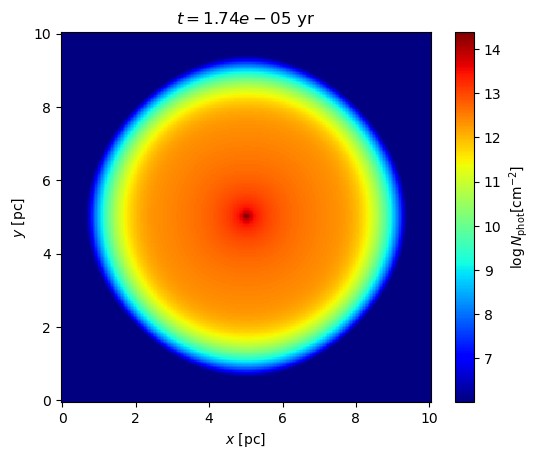

In [17]:
plt.pcolormesh(grid.x*unit.length/constants.pc, grid.y*unit.length/constants.pc, 
               np.log10(grid.urad[NPHOT]*unit.phot/(unit.length)**2), cmap='jet')
plt.gca().set_aspect(True)
cbar = plt.colorbar()

plt.title(r'$t = %.3g~{\rm yr}$' % (grid.t*unit.time/constants.yr))
plt.xlabel(r'$x$ [${\rm pc}$]')
plt.ylabel(r'$y$ [${\rm pc}$]')
cbar.set_label(r'$\log N_{\rm phot} [\rm cm ^{-2}]$')

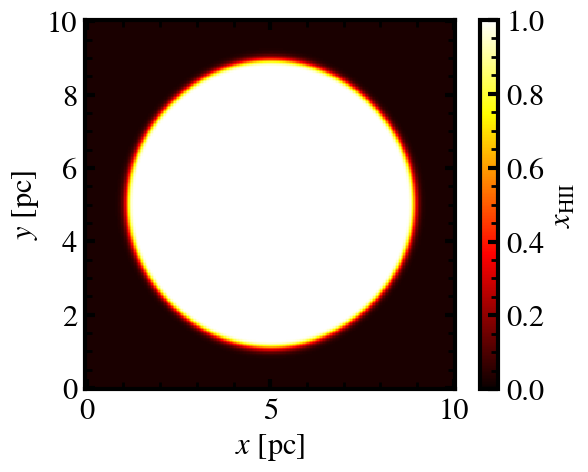

In [21]:
plt.pcolormesh(grid.x*unit.length/constants.pc, grid.y*unit.length/constants.pc, grid.u[ION]/grid.u[RHO], cmap='hot', 
               vmin=0, vmax=1)
plt.gca().set_aspect(True)
cbar = plt.colorbar()

# plt.title(r'$t = %.3g~{\rm yr}$' % (grid.t*unit.time/const.yr))
plt.xlabel(r'$x$ [${\rm pc}$]')
plt.ylabel(r'$y$ [${\rm pc}$]')
cbar.set_label(r'$x_{\rm HII}$')